# Import libraries

In [24]:
import re 
from typing import List, Dict, Optional
import numpy as np
from PIL import Image
import pytesseract
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json

# Bank Classification Function

In [6]:
def classify_bank(image_path: str, model, class_indices) -> str:
    if model is None:
        print("Bank classfication model not loaded. Returning 'Unknown'.")
        return "Unknown"
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_bank = class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]
        
        print(f"Predicted bank: {predicted_bank} with confidence: {confidence:.2f}")
        return predicted_bank
    except Exception as e:
        print(f"Error during bank classification: {e}")
        return "Unknown"

# Image Preprocessing

In [18]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    
    return thresh

# Data Extraction Function

In [38]:
def extract_data_aba(image) -> dict:
    
    # Extract all data
    custom_config = r'--oem 3 --psm 6'
    extracted_text = pytesseract.image_to_string(image, config=custom_config)
    
    extracted_text = extracted_text.strip()
    
    # Build the pattern
    pattern = {
        "transaction_id": r"Trx. ID: (\d+)",
        "amount": r"Original amount: (\d+\.\d+)",
        "date": r"Transaction date: (.+)"
    }
    
    extracted_data = {}
    
    # Catching data
    for key, regex in pattern.items():
        match = re.search(regex, extracted_text)
        
        if match:
            if key == "amount":
                extracted_data[key] = float(match.group(1))
            else:
                extracted_data[key] = match.group(1)
            
        else: 
            extracted_data[key] = "None"
            
    return extracted_data

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


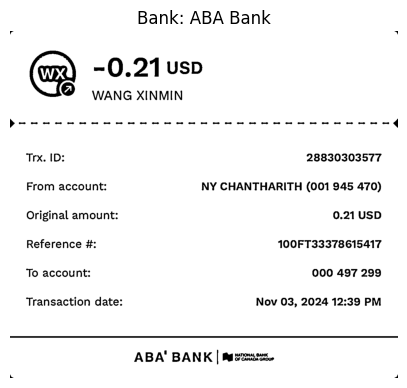

Extracted Transaction Data:
 {
  "transaction_id": "28830303577",
  "amount": 0.21,
  "date": "Nov 03, 2024 12:39 PM"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted bank: ABA Bank with confidence: 1.00


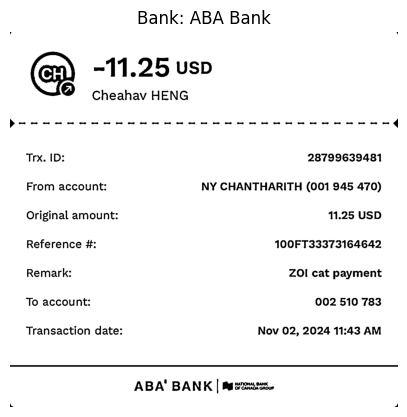

Extracted Transaction Data:
 {
  "transaction_id": "28799639481",
  "amount": 11.25,
  "date": "Nov 02, 2024 11:43 AM"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted bank: ABA Bank with confidence: 1.00


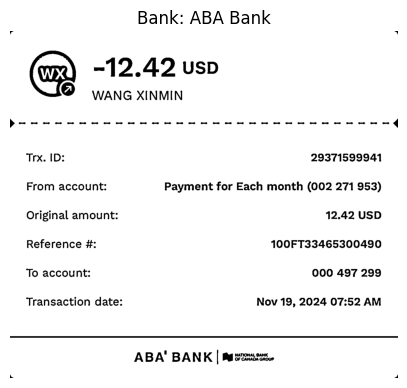

Extracted Transaction Data:
 {
  "transaction_id": "29371599941",
  "amount": 12.42,
  "date": "Nov 19, 2024 07:52 AM"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted bank: ABA Bank with confidence: 0.99


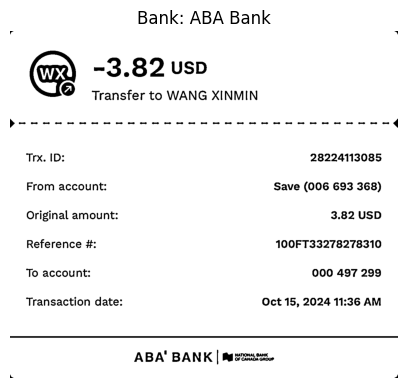

Extracted Transaction Data:
 {
  "transaction_id": "28224113085",
  "amount": 3.82,
  "date": "Oct 15, 2024 11:36 AM"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted bank: ABA Bank with confidence: 1.00


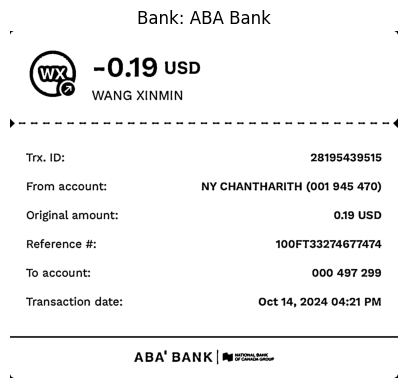

Extracted Transaction Data:
 {
  "transaction_id": "28195439515",
  "amount": 0.19,
  "date": "Oct 14, 2024 04:21 PM"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted bank: ABA Bank with confidence: 0.99


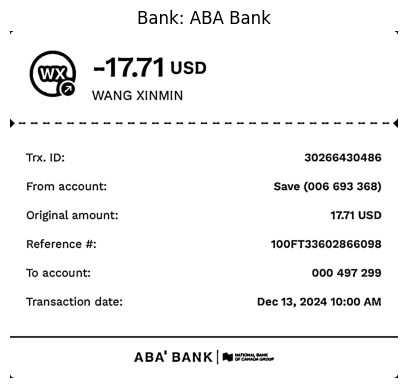

Extracted Transaction Data:
 {
  "transaction_id": "30266430486",
  "amount": 17.71,
  "date": "Dec 13, 2024 10:00 AM"
}
Total amount: 45.6


In [41]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES =["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test/"

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', 'jpeg', 'PNG'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image(image_path)
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    print(f"Extracted Transaction Data:\n {json.dumps(extracted_data, indent=2)}")
    
    amount.append(extracted_data['amount'])

print(f"Total amount: {sum(amount)}")